## Uncertainity in Deep Learning

Taken from http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html#uncertainty-sense

Also see: https://alexgkendall.com/computer_vision/bayesian_deep_learning_for_safe_ai/

In [1]:
%matplotlib inline

import numpy as np
import torch
from torch.autograd import Variable

from matplotlib import animation
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, trange
from ipywidgets import interact, fixed
from IPython.display import HTML


In [2]:
sns.set_context("poster")
sns.set_style("ticks")

np.random.seed(101217209)

In [3]:
def get_data(N, min_x, max_x):
    w, b = np.random.randn(2)
    def true_model(X):
        lin_factor = w * X + b
        y = np.sin(lin_factor*10)*(lin_factor**2)
        return y
    X_true = np.arange(min_x, max_x, 0.01)
    y_true = true_model(X_true)
    span = (max_x - min_x)
    scale = 0.2
    X_obs = min_x + span*scale + np.random.rand(N)*(span - 2*scale*span)
    y_obs = true_model(X_obs) + np.random.randn(N)*0.1
    return (X_obs, y_obs, X_true, y_true), (w, b, true_model)
    

In [4]:
N = 30
min_x, max_x = -1, 1
(X_obs, y_obs, X_true, y_true), (w, b, true_model) = get_data(N, min_x, max_x)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


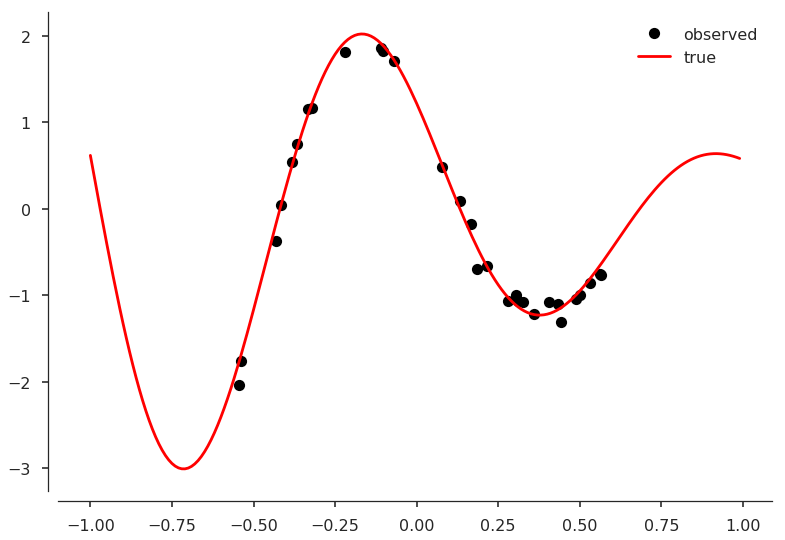

In [5]:
plt.plot(X_obs, y_obs, ls="none", marker="o", color="k", label="observed")
plt.plot(X_true, y_true, ls="-", color="r", label="true")
plt.legend()
sns.despine(offset=10)

In [6]:
class SimpleModel(torch.nn.Module):
    def __init__(self, p=0.05, decay=0.001):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(1,20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20, 20),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)
    
def uncertainity_estimate(X, model, iters, l2=0.005, range_fn=trange):
    outputs = np.hstack([model(X[:, np.newaxis]).data.numpy() for i in range_fn(iters)])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    tau = l2 * (1-model.dropout_p) / (2*N*model.decay)
    y_variance += (1/tau)
    y_std = np.sqrt(y_variance) #+ (1/tau)
    return y_mean, y_std

def plot_model(model, iters=200, l2=0.005, n_std=3, ax=None):
    if ax is None:
        plt.close("all")
        plt.clf()
        fig, ax = plt.subplots(1,1)
    y_mean, y_std = uncertainity_estimate(X_true, model, iters, l2=l2)
    
    ax.plot(X_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
    ax.plot(X_true, y_true, ls="-", color="r", label="true")
    ax.plot(X_true, y_mean, ls="-", color="b", label="mean")
    for i in range(n_std):
        ax.fill_between(
            X_true,
            y_mean - y_std * ((i+1)/2),
            y_mean + y_std * ((i+1)/2),
            color="b",
            alpha=0.5**(i+1)
        )
    ax.legend()
    sns.despine(offset=10)
    return ax

In [7]:
model = SimpleModel(p=0.01, decay = 0.001)

In [8]:
y_mean, y_std = uncertainity_estimate(X_true, model, 200)

100%|██████████| 200/200 [00:00<00:00, 1558.64it/s]


In [9]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    weight_decay=model.decay)

In [10]:
def fit_model(model, optimizer):
    y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
    y_pred = model(X_obs[:, np.newaxis])
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss

100%|██████████| 200/200 [00:00<00:00, 1214.44it/s]


loss=Variable containing:
1.00000e-02 *
  1.5206
[torch.FloatTensor of size 1]



/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


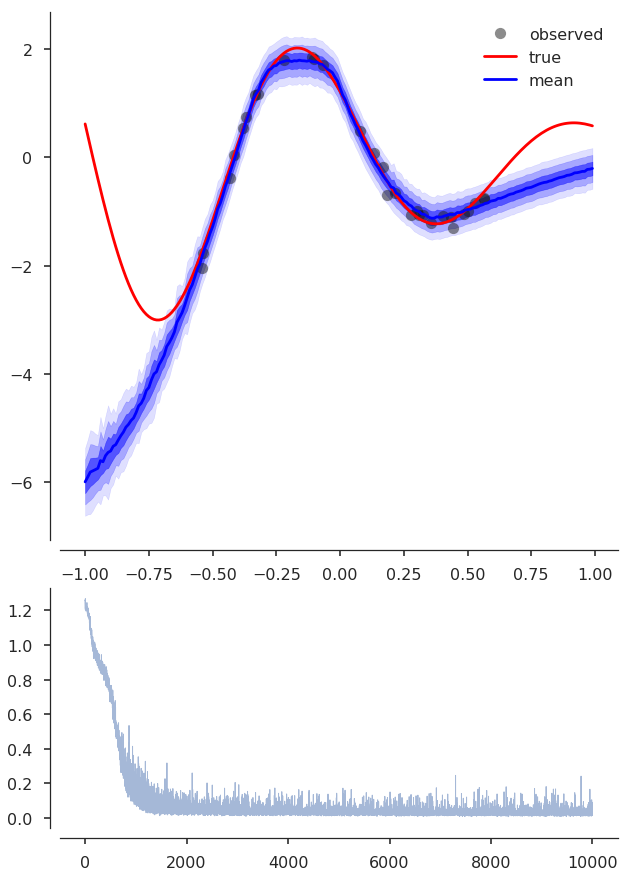

In [11]:
fig = plt.figure(figsize=(10, 15))
ax0 = plt.subplot2grid((3,1), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((3,1), (2, 0))
losses = []
for i in trange(10000):
    loss = fit_model(model, optimizer)
    losses.append(loss.data.numpy()[0])
print("loss={}".format(loss))
ax1.plot(losses, ls="-", lw=1, alpha=0.5)
plot_model(model, l2=1, ax=ax0)

100%|██████████| 200/200 [00:00<00:00, 1870.97it/s]


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


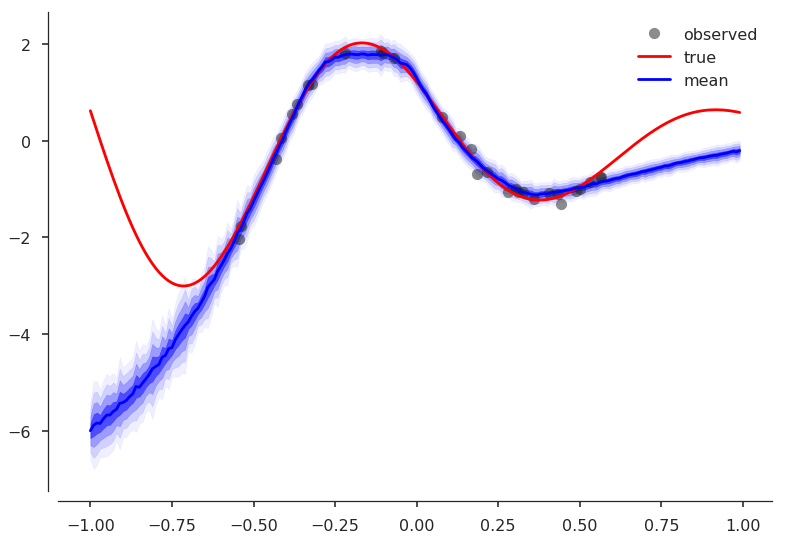

In [12]:
plot_model(model, n_std=4, l2=10)

## Make animation

In [13]:
class AnimateTraining(object):
    def __init__(self, model, u_iters=200, l2=1, n_std=4):
        self.model = model
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(
            model.parameters(),
            weight_decay=model.decay)
        
        self.losses = []
        self.n_std = n_std
        self.u_iters = u_iters
        self.l2 = l2
        
        ## plot items
        self.fig, self.ax0 = plt.subplots(1,1)
        
        self.ax0.plot(X_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
        self.ax0.plot(X_true, y_true, ls="-", color="r", label="true")
        self.ln_mean, = self.ax0.plot([], [], ls="-", color="b", label="mean")
        
        self.loss_text = self.ax0.set_title('', fontsize=15)
        
        self.fill_stds = []
        for i in range(self.n_std):
            fill_t = self.ax0.fill_between(
                [], [], [],
                color="b",
                alpha=0.5**(i+1)
            )
            self.fill_stds.append(fill_t)
            
        self.ax0.legend(loc="upper left")
        
        
    def fit_model(self):
        y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
        y_pred = self.model(X_obs[:, np.newaxis])
        self.optimizer.zero_grad()
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss
            
    def init_plot(self):
        self.ln_mean.set_data([], [])
        self.loss_text.set_text('')
        return self.ln_mean, self.loss_text
    
    def animate_plot(self, i):
        for j in range(100):
            loss = self.fit_model().data.numpy()[0]
            self.losses.append(loss)
        
        self.loss_text.set_text('loss[{}]={:.3f}'.format((i+1)*100, loss))
        
        y_mean, y_std = uncertainity_estimate(
            X_true, self.model, self.u_iters, l2=self.l2,
            range_fn=range
        )
        
        self.ln_mean.set_data(X_true, y_mean)
        for i in range(self.n_std):
            self.fill_stds[i].remove()
            self.fill_stds[i] = self.ax0.fill_between(
                X_true,
                y_mean - y_std * ((i+1)/2),
                y_mean + y_std * ((i+1)/2),
                color="b",
                alpha=0.5**(i+1)
            )
        return [self.ln_mean, self.loss_text] + self.fill_stds
        
        
    def train(self, iters, interval=100):
        anim = animation.FuncAnimation(
            self.fig, self.animate_plot, init_func=self.init_plot,
            frames=range(iters), interval=interval, blit=True)
        return HTML(anim.to_html5_video())


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


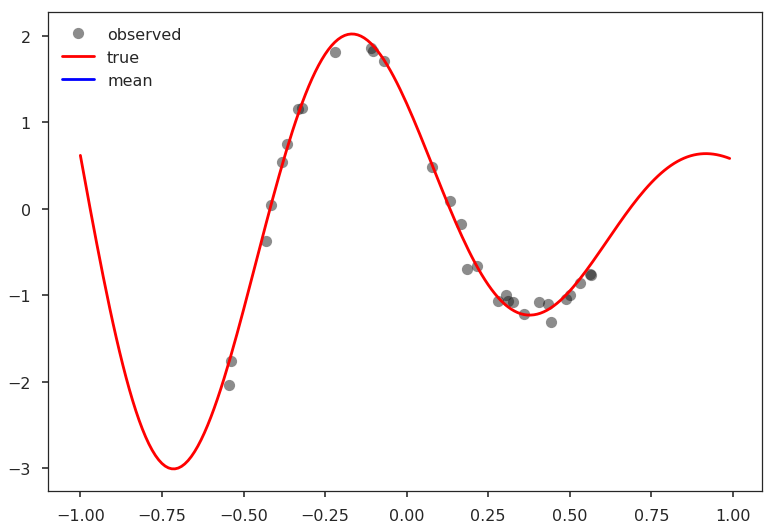

In [14]:
model = SimpleModel(p=0.01, decay = 0.001)
animate_obj = AnimateTraining(SimpleModel(p=0.01, decay = 0.001))

In [15]:
animate_obj.train(100, interval=100)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
